# Nonlinear dynamics Python computational model

This example demonstrates how to define a Python computational model in UQpy - see **section 2.2** in the accompanying paper "UQpy: A general purpose Python package and development environment for uncertainty quantification".  

This notebook makes use of the following files:
- utils_dynamics.py contains the Python functions that define the computational model
- USACA47.035.txt contains a ground motion time series (El-Centro earthquake, data downloaded from the Center for   Engineering Strong Motion Data).

## Description of the computational model

The system consists in a highly nonlinear single degree of freedom system represented by a Bouc-Wen model of hysteresis:

\begin{align*}
& m \ddot{z}(t) + c \dot{z}(t) + k r(t) = - \ddot{u} \\
& \dot{r}(t) = \dot{z} - \beta \vert\dot{z}(t)\vert \vert r(t) \vert^{n-1} r(t) - \gamma \dot{z}(t) \vert r(t) \vert^{n}
\end{align*}

where $\ddot{u}$ is the ground motion exciting the system (in $cm.s^2$). The system is parameterized by a stiffness and damping parameters $k, c$ and parameters of the Bouc-Wen model of hysteresis $r_{0}=\sqrt[n]{\frac{1}{\beta-\gamma}}, \delta=\frac{\beta}{\beta+\gamma}, n$. Forward simulation of the problem, for a given input excitation time series and a parameter vector, is performed via a fourth-order Runge-Kutta method. Codes are are written in the python script utils_dynamics.py.
<br>
Stochasticity can arise from two distinct sources:
- stochasticity of the input excitation $\ddot{u}(t)$,
- randomness in the system parameters.
<br>

In the UQpy framework, the user defines the deterministic forward model QoI=h(q) via the RunModel module, where q is the input uncertainty. This notebook illustrates the usage of the RunModel module to define two models. The first model integrates both types of uncertainties and will be used for uncertainty propagation. The second model solely considers uncertainties in the model parameters - it will be used for inference tasks.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from utils_dynamics import *

## Part 1: Combined uncertainty from stochastic input ground motion and model parameters

The QoI consists in the displacement time series of the Bouc-Wen SDOF system. The following cell shows how to instantiate a RunModel object. The function h must take as first argument one sample of the combined uncertainties (model parameters $k [cN/cm], r_{0} [cm], \delta, n$ and input excitation random vector). In this example, this function also takes in a second arugment, namely the time vector that correspond to the stochastic excitation (assumed the same for all samples of the input excitation). This additional parameter is provided to the RunModel object as a keyword argument (time_vec).

In [2]:
from UQpy.RunModel import RunModel
dyn_model_prop = RunModel(
    model_script='utils_dynamics.py', model_object_name='sdof_boucwen_prop', ntasks=1, 
    time_vec=np.arange(0., 40.01, 0.02), vec=False, var_names=['k', 'r0', 'delta', 'n', 'input_accel'])

To instantiate a single run, the user must provide the samples, here a single time series of the input ground acceleration and a parameter vector.

In [3]:
_, accel = read_elcentro(scale=0.1)    # the input ground motion is read from a file
#print(accel.shape)

samples = [[np.array(1.0).reshape((-1,)), np.array(2.5).reshape((-1,)), np.array(0.9).reshape((-1,)), 
            np.array(3.).reshape((-1,)), accel],
          ]
#samples = [[1., 2.5, 0.9, 3., accel],]
#print(samples)

print('Number of samples:')
print(len(samples))
print('Dimension of input random variables:')
print(len(samples[0]))

Number of samples:
1
Dimension of input random variables:
5


In [4]:
dyn_model_prop.run(samples=samples)
qoi = dyn_model_prop.qoi_list[0]

[1.  2.5 0.9 3. ]
[ 0.5991  0.1857  0.68   ... -0.1808 -0.5598 -0.7639]


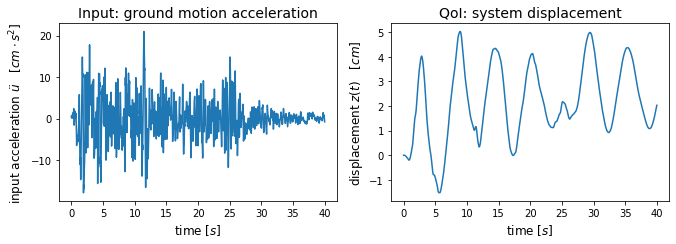

In [5]:
# Plot excitation and displacement qoi
fig, ax = plt.subplots(ncols=2, figsize=(9.5, 3.5))
ax[0].plot(np.arange(0., 40.01, 0.02), accel)
ax[0].set_xlabel('time $[s]$', fontsize=12)
ax[0].set_ylabel('input acceleration $\ddot{u} \quad [cm \cdot s^{2}]$', fontsize=12)
ax[0].set_title('Input: ground motion acceleration', fontsize=14)
ax[1].plot(np.arange(0., 40.01, 0.02), qoi)
ax[1].set_xlabel('time $[s]$', fontsize=12)
ax[1].set_ylabel('displacement $z(t) \quad [cm]$', fontsize=12) 
ax[1].set_title('QoI: system displacement', fontsize=14)
fig.tight_layout()
plt.show(fig)

## Part 2: Randomness from the system parameters

In the following, the QoI consists in the displacement time series of the Bouc-Wen SDOF system, and the stochastic input q is the vector of system parameters $k [cN/cm], r_{0} [cm], \delta, n$. The input excitation is deterministic (scaled el-centro earthquake ground motion).

In this setting, the forward function h takes in as first argument samples of the system parameters (ndarray of shape (N, d) where d=4 herein). The function also takes a couple of additional arguments:
- scale_factor, which indicates the scale of the input excitation, default is 1.
- return_Rf, if set to True both the displacement and reaction force time series are returned as qois, otherwise only the displacement time-series is returned (default is False).

In [6]:
from UQpy.RunModel import RunModel
scale_factor = 0.1
dyn_model_infce = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_boucwen_infce', ntasks=4, 
                           scale_factor=scale_factor, return_Rf=True, vec=False, 
                           var_names=['k', 'r0', 'delta', 'n'])

In [7]:
samples = np.array([1.0, 2.5, 0.9, 3.]).reshape((1, 4))
dyn_model_infce.run(samples=samples)
qoi = dyn_model_infce.qoi_list[0]

[1.  2.5 0.9 3. ]


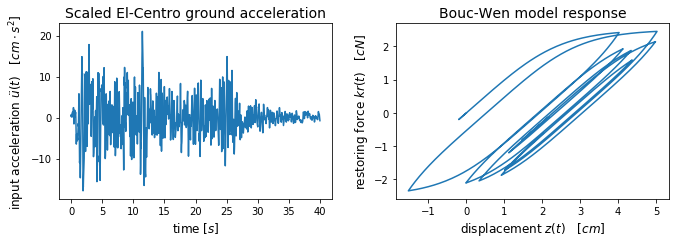

In [8]:
# Plot excitation and solution (displacement - force plot)
fig, ax = plt.subplots(ncols=2, figsize=(9.5, 3.5))
time_vec, accel = read_elcentro(scale=scale_factor)
ax[0].plot(time_vec, accel)
ax[0].set_xlabel('time $[s]$', fontsize=12)
ax[0].set_ylabel('input acceleration $\ddot{u}(t) \quad [cm \cdot s^{2}]$', fontsize=12)
ax[0].set_title('Scaled El-Centro ground acceleration', fontsize=14)
ax[1].plot(qoi[0], qoi[1])
ax[1].set_xlabel('displacement $z(t) \quad [cm]$', fontsize=12) 
ax[1].set_ylabel(r'restoring force $k r(t) \quad [cN]$', fontsize=12); 
ax[1].set_title('Bouc-Wen model response', fontsize=14)
fig.tight_layout()
#fig.savefig('dynamics_model_2.pdf')
plt.show(fig)